# mRNA-miRNA Drive Train

This experiments performs two models of gene-gene interaction:

1. Modeling gene-gene interactions of miRNA
2. Modeling gene-gene interactions of mRNA targeted by miRNA from 1

The goal is to test whether there are differences in interactions between mRNA and miRNA models.

## Import Modules

Load all required modules for this script

In [1]:
import os.path as op               # path management
import numpy as np                 # matrix manipulation
import pandas as pd                # database management
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import seaborn as sns              # plotting
import matplotlib.pyplot as plt    # plotting

## Define Paths

Define paths to relevant CSV files

In [2]:
path_mirna_c1 = 'D:\\Datasets\\RNAS-Seq\\miRNA\\Correlations\\CvsN\\corr_miRNA_C.xlsx'
path_mirna_c2 = 'D:\\Datasets\\RNAS-Seq\\miRNA\\Correlations\\CvsN\\corr_miRNA_N.xlsx'
path_mrna_c = 'D:\\Datasets\\RNAS-Seq\\mRNA\\Generated_Data\\CvsN\\cr-CvsN.csv'
path_target = 'D:\\Datasets\\RNAS-Seq\\miRNA\\Targets\\miRNA_Targets_CvsN.xlsx'
path_out = 'D:\\Datasets\\RNAS-Seq\\miRNA\\Plots'

## Define Fixed Variables

Define variables that can be changed to control granularity of script.

In [3]:
labels = ['C', 'N']   # analysis being performed
bins = 10               # number of bins to use in plotting
sns.set_style('darkgrid')

## Run Script

Executes the script

In [4]:
mirna_c1 = pd.read_excel(path_mirna_c1)
mirna_c2 = pd.read_excel(path_mirna_c2)
mrna_c = pd.read_csv(path_mrna_c, header=None)
target = pd.read_excel(path_target, header=None, index_col=0)

mirna_c1_ = mirna_c1.copy()
mirna_c2_ = mirna_c2.copy()
# Convert all correlations to positive
mirna_c1[mirna_c1.columns[mirna_c1.dtypes != np.object]] = mirna_c1[mirna_c1.columns[mirna_c1.dtypes != np.object]].abs()
mirna_c2[mirna_c2.columns[mirna_c2.dtypes != np.object]] = mirna_c2[mirna_c2.columns[mirna_c2.dtypes != np.object]].abs()
mrna_c[mrna_c.columns[mrna_c.dtypes != np.object]] = mrna_c[mrna_c.columns[mrna_c.dtypes != np.object]].abs()

target_ = []
for k, v in target.iterrows():
    target_.extend(v.dropna())
target = list(set(target_))

idx1 = np.array(pd.DataFrame(mrna_c.iloc[:,0].tolist()).isin(target).any(1).to_list())
idx2 = np.array(pd.DataFrame(mrna_c.iloc[:,1].tolist()).isin(target).any(1).to_list())
idx = idx1 * idx2
mrna_c = mrna_c.iloc[idx, :]

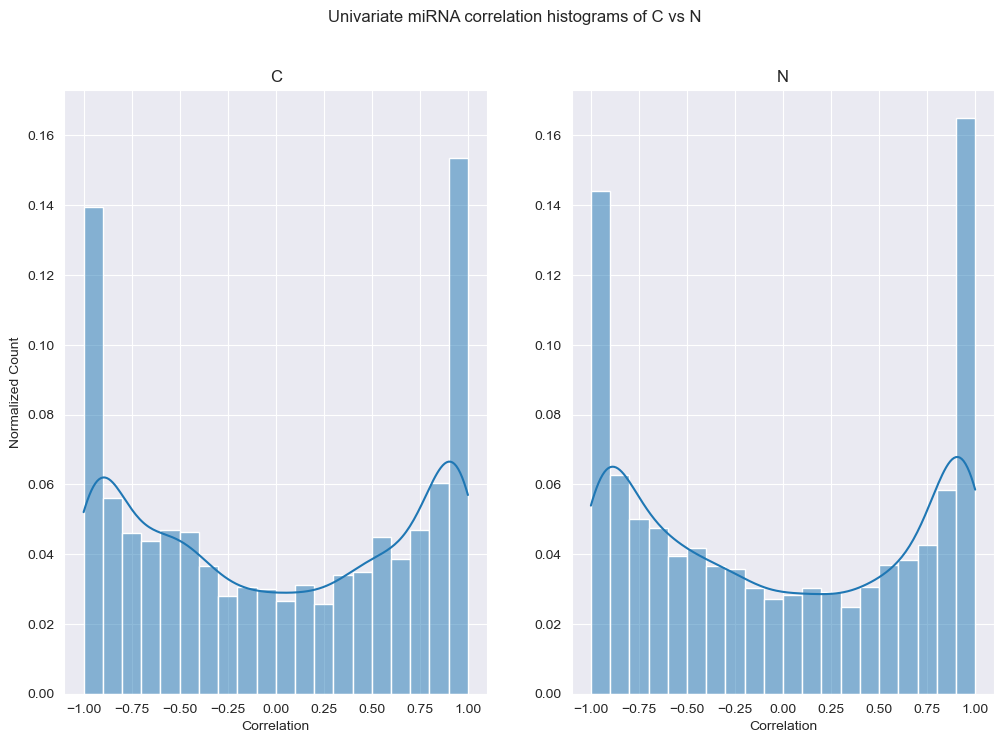

In [5]:
# Make Plot
fname = op.join(path_out, 'unihist_miRNA_' + labels[0] + 'vs' + labels[1] + '.jpg')
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1,2,1)
sns.histplot(mirna_c1_.loc[:, 'Corr'], bins=2*bins, kde=True, stat='probability')
plt.xlabel('Correlation')
plt.ylabel('Normalized Count')
plt.title(labels[0])
ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
sns.histplot(mirna_c2_.loc[:, 'Corr'], bins=2*bins, kde=True, stat='probability')
plt.xlabel('Correlation')
plt.ylabel('')
plt.title(labels[1])
plt.suptitle('Univariate miRNA correlation histograms of {} vs {}'.format(labels[0], labels[1]))
plt.savefig(fname, dpi=300)
# Save plot data
fname = op.join(path_out, 'unihist_miRNA_' + labels[0] + 'vs' + labels[1] + '.csv')
c1_data = [[h.xy[0], h.get_width(), h.get_height()] for h in  ax1.patches]
c2_data = [[h.xy[0], h.get_width(), h.get_height()] for h in  ax2.patches]
row = []
c1_count = []
c2_count = []
for i in range(len(c1_data)):
    row.append('{:.1f} to {:.1f}'.format(c1_data[i][0], c1_data[i][1]))
    c1_count.append(c1_data[i][2])
    c2_count.append(c2_data[i][2])
df_miRNA = pd.DataFrame(
    {
        'Bin Range': row,
        labels[0]: c1_count,
        labels[1]: c2_count
    }
)
df_miRNA.index.name = 'Bin #'
df_miRNA.to_csv(fname)

In [6]:
h_mirna_c1, e_mirna_c1 = np.histogram(mirna_c1.iloc[:, 2], bins=bins, density=False)
m_mirna_c1 = []
for i in range(len(e_mirna_c1)-1):
    m_mirna_c1.append(np.median((e_mirna_c1[i], e_mirna_c1[i+1])))
m_mirna_c1 = np.array(m_mirna_c1)
h_mirna_c1 = (h_mirna_c1 - np.min(h_mirna_c1)) / (np.max(h_mirna_c1) - np.min(h_mirna_c1))

h_mirna_c2, e_mirna_c2 = np.histogram(mirna_c2.iloc[:, 2], bins=bins, density=False)
m_mirna_c2 = []
for i in range(len(e_mirna_c2)-1):
    m_mirna_c2.append(np.median((e_mirna_c2[i], e_mirna_c2[i+1])))
m_mirna_c2 = np.array(m_mirna_c2)
h_mirna_c2 = (h_mirna_c2 - np.min(h_mirna_c2)) / (np.max(h_mirna_c2) - np.min(h_mirna_c2))
    
h_mrna_c1, e_mrna_c1 = np.histogram(mrna_c.iloc[:, 2], bins=bins, density=False)
m_mrna_c1 = []
for i in range(len(e_mrna_c1)-1):
    m_mrna_c1.append(np.median((e_mrna_c1[i], e_mrna_c1[i+1])))
m_mrna_c1 = np.array(m_mrna_c1)
h_mrna_c1 = (h_mrna_c1 - np.min(h_mrna_c1)) / (np.max(h_mrna_c1) - np.min(h_mrna_c1))
    
h_mrna_c2, e_mrna_c2 = np.histogram(mrna_c.iloc[:, 3], bins=bins, density=False)
m_mrna_c2 = []
for i in range(len(e_mrna_c2)-1):
    m_mrna_c2.append(np.median((e_mrna_c2[i], e_mrna_c2[i+1])))
m_mrna_c2 = np.array(m_mrna_c2)
h_mrna_c2 = (h_mrna_c2 - np.min(h_mrna_c2)) / (np.max(h_mrna_c2) - np.min(h_mrna_c2))

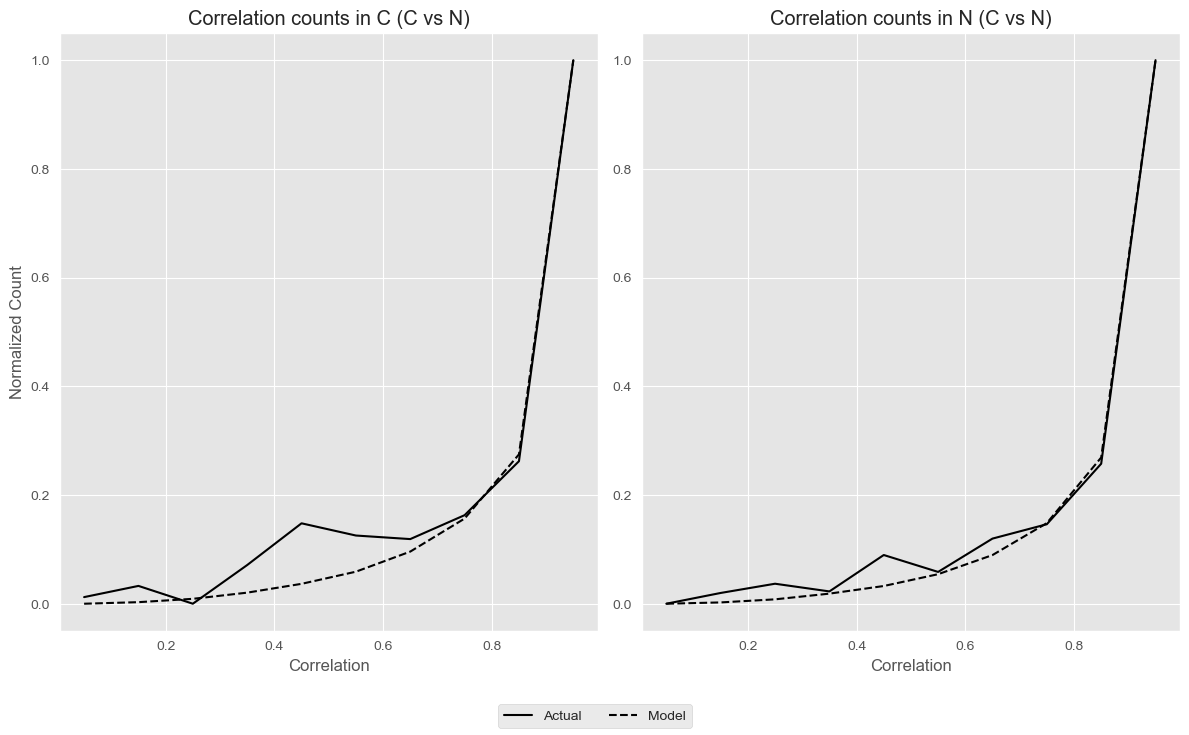

In [7]:
# Make plot
fname = op.join(path_out, 'models_' + labels[0] + 'vs' + labels[1] + '.jpg')
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
ax1 = plt.subplot(1,2,1, aspect='equal')
plt.plot(m_mirna_c1, h_mirna_c1, 'k-', m_mrna_c1, h_mrna_c1, 'k--')
plt.xlabel('Correlation')
plt.ylabel('Normalized Count')
plt.title('Correlation counts in {} ({} vs {})'.format(labels[0], labels[0], labels[1]))
ax2 = plt.subplot(1,2,2, aspect='equal', sharex=ax1, sharey=ax1)
plt.plot(m_mirna_c2, h_mirna_c2, 'k-', m_mrna_c2, h_mrna_c2, 'k--')
plt.xlabel('Correlation')
plt.title('Correlation counts in {} ({} vs {})'.format(labels[1], labels[0], labels[1]))
fig.legend(['Actual', 'Model'], loc='lower center', ncol=2)
plt.tight_layout()
plt.savefig(fname, dpi=300)
# Save plot data
fname = op.join(path_out, 'models_' + labels[0] + 'vs' + labels[1] + '.csv')
df_models = pd.DataFrame(
    {
        'miRNA_{}_x (actual)'.format(labels[0]): m_mirna_c1,
        'miRNA_{}_y (actual)'.format(labels[0]): h_mirna_c1,
        'mRNA_{}_x (model)'.format(labels[0]): m_mrna_c1,
        'mRNA_{}_y (model)'.format(labels[0]): h_mrna_c1,
        'miRNA_{}_x (actual)'.format(labels[1]): m_mirna_c2,
        'miRNA_{}_y (actual)'.format(labels[1]): h_mirna_c2,
        'mRNA_{}_x (model)'.format(labels[1]): m_mrna_c2,
        'mRNA_{}_y (model)'.format(labels[1]): h_mrna_c2
    }
)
df_models.index.name = 'Bin #'
df_models.to_csv(fname)

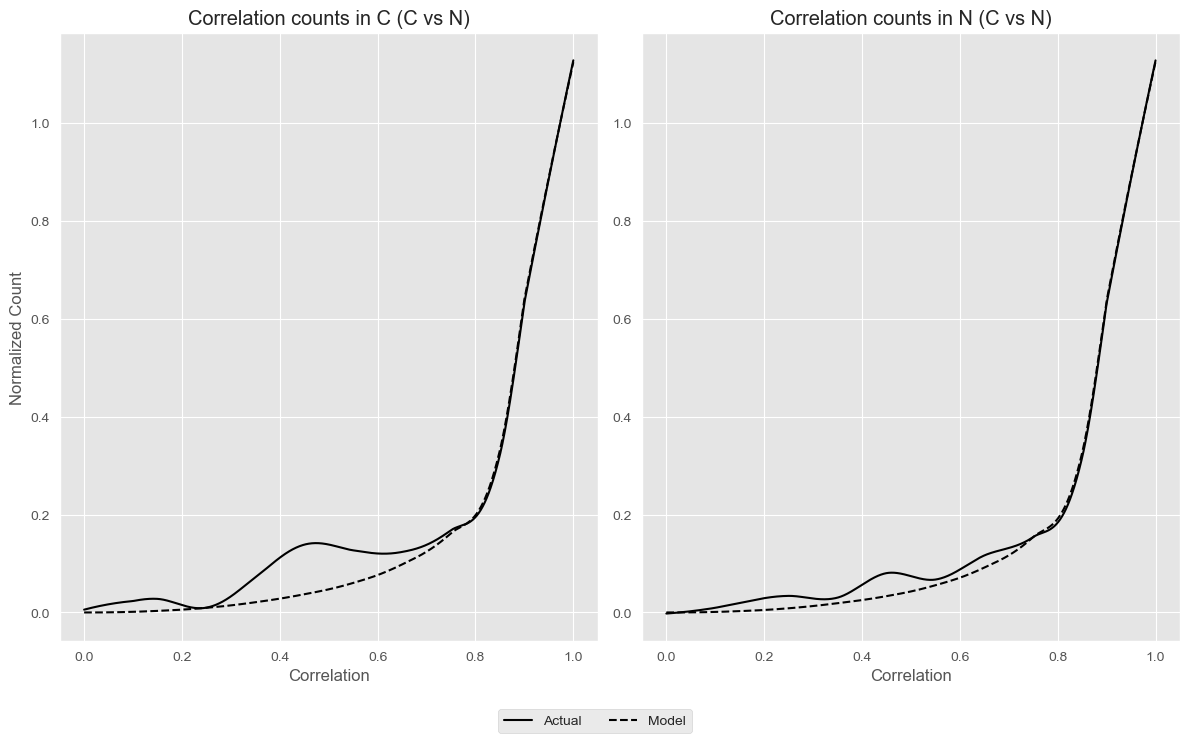

In [8]:
x = np.linspace(0,1,1000)
h_mirna_c1 = savgol_filter(np.interp(x, m_mirna_c1, h_mirna_c1), 201, 2)
h_mirna_c2 = savgol_filter(np.interp(x, m_mirna_c2, h_mirna_c2), 201, 2)
h_mrna_c1 = savgol_filter(np.interp(x, m_mrna_c1, h_mrna_c1), 201, 2)
h_mrna_c2 = savgol_filter(np.interp(x, m_mrna_c2, h_mrna_c2), 201, 2)

fname = op.join(path_out, labels[0] + 'vs' + labels[1] + '_smooth.jpg')
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
ax1 = plt.subplot(1,2,1, aspect='equal')
plt.plot(x, h_mirna_c1, 'k-', x, h_mrna_c1, 'k--')
plt.xlabel('Correlation')
plt.ylabel('Normalized Count')
plt.title('Correlation counts in {} ({} vs {})'.format(labels[0], labels[0], labels[1]))
ax2 = plt.subplot(1,2,2, aspect='equal', sharex=ax1, sharey=ax1)
plt.plot(x, h_mirna_c2, 'k-', x, h_mrna_c2, 'k--')
plt.xlabel('Correlation')
plt.title('Correlation counts in {} ({} vs {})'.format(labels[1], labels[0], labels[1]))
fig.legend(['Actual', 'Model'], loc='lower center', ncol=2)
plt.tight_layout()
plt.savefig(fname, dpi=300)